In [3]:
import torch
import torch.nn as nn
import itertools
import numpy as np
import matplotlib.pyplot as plt

(0.0, 9.0)

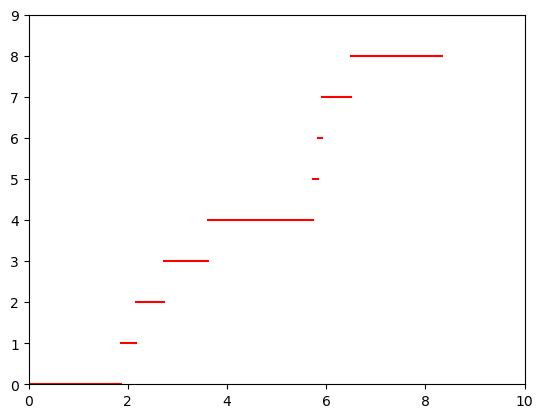

In [7]:
lam = 1  # 参数为1.5的泊松过程
T = 10  # 时间到T
n = np.random.poisson(lam * T)  # T时间内发生的次数
# 生成n个[0, T]均匀分布随机数并排序
t = np.hstack([[0], np.sort(np.random.random(n) * T)])
for i in range(n):
    plt.plot((t[i], t[i+1]), (i, i), c='r')
plt.plot((t[i+1], T), (n, n), c='r')
plt.xlim([0, T])
plt.ylim([0, n])

In [4]:
np.random.exponential(scale=1., size=10)

array([0.23026037, 1.32320875, 0.24510373, 0.72080276, 0.88421667,
       0.00175209, 0.72795267, 0.00133543, 0.39971817, 0.76578267])

In [ ]:
class MCModel(nn.Module):
    """
    Markov chain approximation (homogeneous case)
    """

    def __init__(
        self,
        mu_init: float,
        sigma: float,
        a: float,
        z: float,
        dt: float,
        Nx: int,
    ) -> None:
        super(MCModel, self).__init__()
        self.mu = nn.Parameter(torch.tensor([mu_init]))

        self.sigma = sigma  # diffusion coeff (constant)
        self.a, self.z = a, z  # upper boundary & starting point
        self.Nx = Nx  # num of space steps
        dx = a / Nx
        self.dt, self.dx = dt, dx

        self.idx_z = int(round(z / dx))  # index of starting point
        self.init_dist = torch.zeros((1, self.Nx + 2))
        self.init_dist[0, self.idx_z] = 1

    def forward(self, T, s):
        """
        compute the probability of P(X[T]=s) with a exponential scaling
        where t is the first passage time
        by DYNAMIC PROGRAMMING
        s: value in [0, a]
        """
        m1 = self.mu * self.dt
        m2 = (self.mu * self.dt) ** 2 + self.sigma ** 2 * self.dt
        p1 = (m2 / self.dx ** 2 + m1 / self.dx) / 2
        p2 = (m2 / self.dx ** 2 - m1 / self.dx) / 2
        assert p1 + p2 < 1, "p+=%.5f, p0=%.5f, p-=%.5f" % (p1, 1 - p1 - p2, p2)
        probs = torch.cat((p2, 1 - p1 - p2, p1))
        indices = [[0, self.Nx + 1], [self.Nx, self.Nx + 1], [self.Nx + 1, self.Nx + 1]]
        values = torch.tensor([1, 1, 1])
        for i in range(1, self.Nx):
            indices.extend([[i, i - 1], [i, i], [i, i + 1]])
            values = torch.cat((values, probs))
        AdjMat = torch.sparse_coo_tensor(
            list(zip(*indices)), values, size=(self.Nx + 2, self.Nx + 2)
        )
        idx_T = int(round(T / self.dt))
        idx_s = int(round(s / self.dx))
        r = torch.tensor(0)
        scaled_table = AdjMat.to_dense()[:, [idx_s]] / torch.exp(r)
        for t_step in range(idx_T - 2, -1, -1):
            b = torch.sum(torch.sparse.mm(AdjMat, scaled_table))
            r = r + torch.log(b)
            scaled_table = torch.sparse.mm(AdjMat, scaled_table) / b
        return torch.sparse.mm(self.init_dist, scaled_table) * torch.exp(r)

    def loss_fun(self, data):
        """
        compute the average negative log likelihood
        likelihood = product of P(X(Tk)=Ck)
        """
        logprob = 0
        for Tk, Ck in data:
            logprob -= torch.log(self.forward(Tk, Ck))
            if torch.isinf(logprob):
                raise ValueError("Infty detected, computation is stopped.")
        return logprob.squeeze() / len(data)

In [ ]:
def train_sgd(model, data, num_epochs=100):
    loss_history, mu_history = [], []
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    # define closure
    def closure():
        optimizer.zero_grad()
        loss = model.loss_fun(data)
        loss.backward()
        return loss
    for epoch in range(num_epochs + 1):
        # training
        if epoch > 0:
            optimizer.step(closure)
        # evaluation
        loss = model.loss_fun(data).detach().numpy().squeeze()
        para = model.mu.detach().numpy().squeeze()
        print("Epoch %d: Loss: %.5f; Parameters: %.5f" % (epoch, loss, para))
        loss_history.append(loss)
        mu_history.append(para)
        # check convergence
        if epoch > 0 and np.abs(loss - loss_history[-2]) < 1e-4:
            break
    print("Optimization ends.")
    return np.array(loss_history), np.array(mu_history)

In [7]:
data = np.load('../data.npy')
data.shape

(1000, 2)

In [8]:
ddm = MCModel(mu_init=1., sigma=1, a=4, z=1.5, dt=0.001, Nx=40)

In [9]:
train(ddm, data[100:200])